In [279]:
'''
grand average plots based on pile_all mat files generated by compare_constructs_GCaMP96uf
'''

from scipy.io import loadmat
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ap_idx = 3 # 0: 1AP, 1: 3AP, 2:10AP, 3:160AP

plot_subset_for_paper = 1 # 0: plot entire dataset, save as html. 1: plot subset, save as pdf for paper
html_write_dir = r'D:\site\ilyakolb.github.io\interactive_norm_plots.html'
pdf_dir = r"D:\ufgcamp_paper_data\culture-screen-figs/norm_plots.pdf"
plot_mat = loadmat(r'data/unnormPlots_singleWells_struct.mat')

subplot_titles = ['peak dF/F', 'SNR', 'half-rise time (ms)', 'full rise time (ms)', 'half-decay time (ms)']
df_cols = subplot_titles.copy()
df_cols.insert(0,'construct')

# labels and order of legend
if plot_subset_for_paper:
    hits_label = ['jGCaMP8f', 'jGCaMP8m', 'jGCaMP8s', 'GCaMP6s', 'jGCaMP7f', 'jGCaMP7s', 'XCaMP-Gf']# [h[0] for h in hits[0]]
else:
    hits_label = ['jGCaMP8f', 'jGCaMP8m', 'jGCaMP8s','jGCaMP8.712', 'GCaMP6s', 'GCaMP6f', 'jGCaMP7f', 'jGCaMP7s', 
                'jGCaMP7c', 'jGCaMP7b', 'XCaMP-Gf', 'XCaMP-G', 'XCaMP-Gf0']# [h[0] for h in hits[0]]

# magnify the kinetics of the following hits
magnify_hits_label = ['jGCaMP8f', 'jGCaMP8m', 'jGCaMP8s']

all_data = plot_mat['unnormPlots_singleWells_struct'][0]

all_constructs = [c[0] for c in all_plots['construct']]

# create dataframe
df = pd.DataFrame(columns=df_cols)

for construct_idx in range(len(all_constructs)):
    n_wells = len(all_data[construct_idx][1][ap_idx])
    n_cells = all_data[construct_idx][1].shape[1] # TEMPORARY BUGFIX
    
    dff = all_data[construct_idx][1][ap_idx]
    snr = all_data[construct_idx][2][ap_idx] #[:n_cells] # TEMPORARY SNR BUGFIX
    
    # get kinetics, convert to milliseconds
    halfrise = all_data[construct_idx][3][ap_idx]*1000
    fullrise = all_data[construct_idx][4][ap_idx]*1000
    halfdecay = all_data[construct_idx][5][ap_idx]*1000
    
    current_construct = [all_data[construct_idx][0][0]] * n_wells
    df_construct = pd.DataFrame(np.array([current_construct, dff, snr, halfrise, fullrise, halfdecay]).T, columns=df_cols)
    df = df.append(df_construct)

# cast data columns as floats
castdict = {x: 'float' for x in subplot_titles}
df = df.astype(castdict)
print('Saving...', end='')
df.to_pickle('data/grand-avg-data_{}.pkl'.format(ap_idx))
print('Done')

Saving...Done


============1AP============


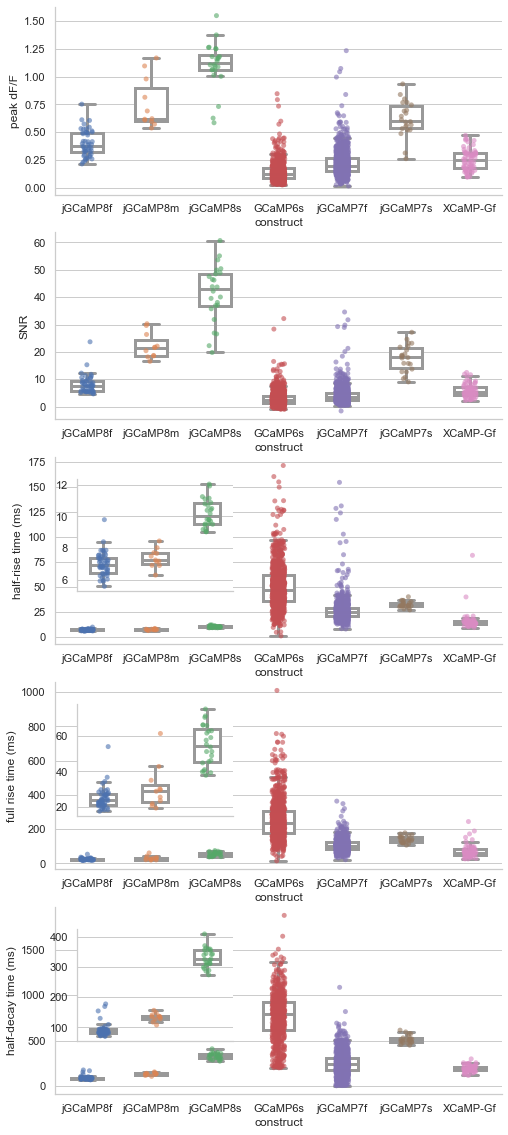

,peak dF/F,SNR,half-rise time (ms),full rise time (ms),half-decay time (ms)
construct,,,,,
GCaMP6f,0.11+/-0.073,1.33+/-1.553,30.99+/-17.423,109.92+/-52.132,300.93+/-72.671
GCaMP6s,0.14+/-0.086,3.07+/-2.807,50.77+/-22.603,257.62+/-118.709,763.94+/-259.231
XCaMP-G,0.25+/-0.101,7.17+/-3.109,19.79+/-5.949,99.22+/-37.26,254.35+/-65.848
XCaMP-Gf,0.25+/-0.095,5.96+/-2.432,15.6+/-8.951,71.08+/-38.202,194.09+/-34.028
XCaMP-Gf0,0.2+/-0.082,4.71+/-2.215,16.91+/-15.307,83.05+/-46.503,219.84+/-62.093
jGCaMP7b,0.56+/-0.13,22.94+/-5.799,43.14+/-3.829,171.17+/-24.239,412.9+/-31.105
jGCaMP7c,0.24+/-0.087,7.19+/-2.639,30.2+/-7.006,165.75+/-34.878,432.38+/-135.227
jGCaMP7f,0.22+/-0.117,4.2+/-3.174,26.55+/-11.719,106.62+/-37.007,253.81+/-121.881
jGCaMP7s,0.62+/-0.159,17.74+/-4.899,32.44+/-3.126,139.78+/-19.601,515.62+/-44.188


============3AP============


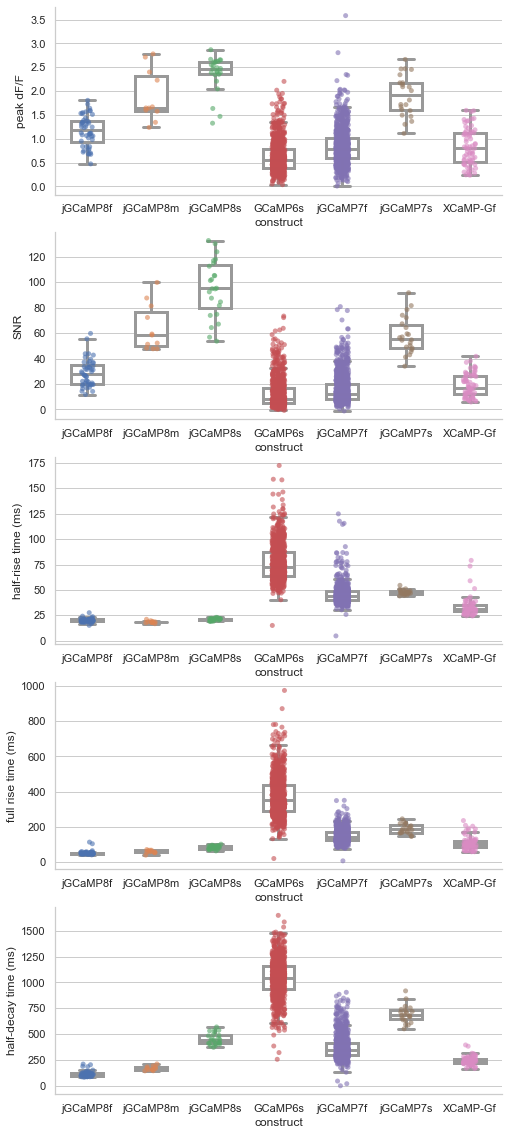

,peak dF/F,SNR,half-rise time (ms),full rise time (ms),half-decay time (ms)
construct,,,,,
GCaMP6f,0.46+/-0.322,6.02+/-8.158,46.58+/-11.997,144.59+/-39.096,302.81+/-62.425
GCaMP6s,0.63+/-0.336,12.84+/-11.504,77.01+/-18.174,373.08+/-116.537,1039.74+/-182.426
XCaMP-G,0.99+/-0.65,26.22+/-16.649,43.68+/-16.593,152.4+/-49.177,318.15+/-55.941
XCaMP-Gf,0.83+/-0.378,19.18+/-9.002,33.48+/-9.499,111.49+/-39.066,245.0+/-41.324
XCaMP-Gf0,0.62+/-0.303,15.38+/-7.572,33.71+/-10.405,129.46+/-43.538,259.34+/-41.907
jGCaMP7b,1.58+/-0.317,65.19+/-14.447,57.83+/-3.407,206.31+/-17.675,520.94+/-26.264
jGCaMP7c,0.94+/-0.306,28.77+/-11.176,51.67+/-5.791,236.03+/-45.103,584.66+/-57.235
jGCaMP7f,0.85+/-0.372,16.21+/-11.762,45.65+/-9.124,149.5+/-36.738,377.46+/-120.36
jGCaMP7s,1.91+/-0.433,58.28+/-14.427,47.73+/-2.407,190.1+/-27.215,694.08+/-83.103


============10AP============


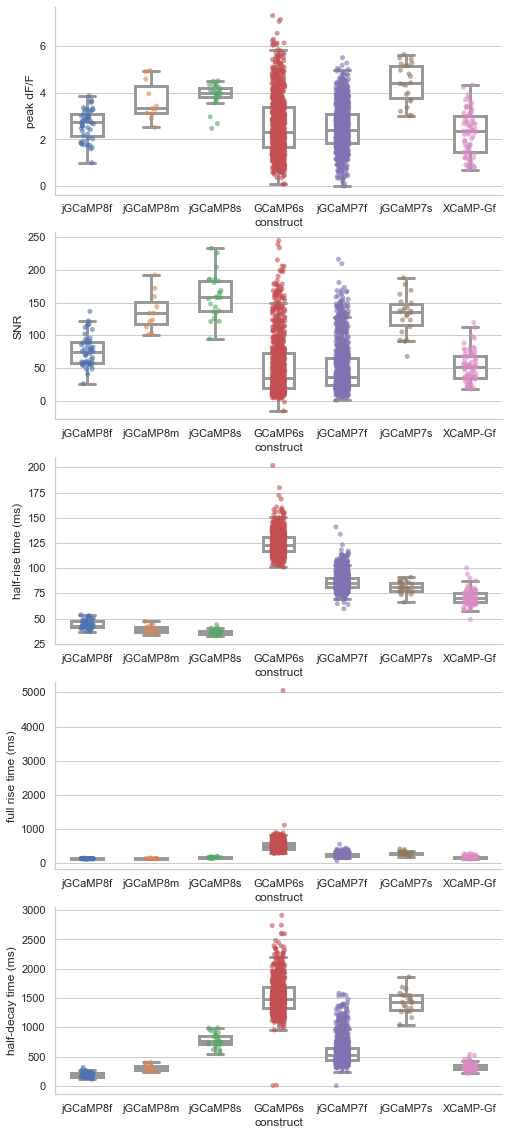

,peak dF/F,SNR,half-rise time (ms),full rise time (ms),half-decay time (ms)
construct,,,,,
GCaMP6f,1.68+/-0.892,21.77+/-19.492,91.76+/-6.911,213.45+/-31.569,372.11+/-79.281
GCaMP6s,2.62+/-1.281,52.44+/-45.625,124.75+/-11.275,518.9+/-195.686,1533.44+/-285.907
XCaMP-G,2.5+/-1.068,67.71+/-26.09,80.4+/-8.191,213.27+/-44.05,432.72+/-78.579
XCaMP-Gf,2.27+/-0.948,52.19+/-22.721,70.99+/-8.282,174.93+/-33.358,326.17+/-65.418
XCaMP-Gf0,1.79+/-0.847,43.51+/-20.836,73.03+/-8.526,184.53+/-57.487,346.76+/-73.783
jGCaMP7b,3.28+/-0.436,136.14+/-20.944,85.39+/-4.272,289.07+/-24.65,971.68+/-101.055
jGCaMP7c,4.3+/-1.376,124.1+/-46.493,106.73+/-6.639,363.74+/-63.631,783.15+/-94.674
jGCaMP7f,2.5+/-0.943,50.27+/-37.564,87.03+/-8.604,239.2+/-42.897,593.29+/-231.524
jGCaMP7s,4.41+/-0.834,131.65+/-29.834,80.98+/-5.875,291.87+/-52.171,1431.88+/-184.014


============160AP============


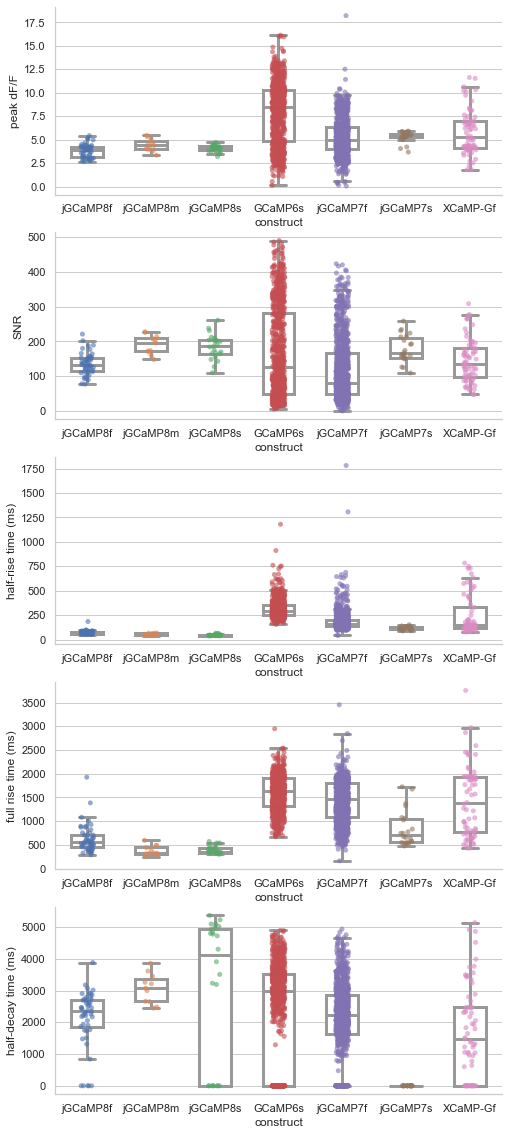

,peak dF/F,SNR,half-rise time (ms),full rise time (ms),half-decay time (ms)
construct,,,,,
GCaMP6f,4.86+/-2.753,76.13+/-74.235,224.15+/-100.271,1343.89+/-524.542,1508.39+/-630.31
GCaMP6s,7.86+/-3.224,167.22+/-130.598,310.8+/-95.625,1601.29+/-369.193,2415.75+/-1576.16
XCaMP-G,5.68+/-1.826,159.21+/-57.813,195.95+/-114.35,1067.77+/-534.188,1506.03+/-1341.016
XCaMP-Gf,5.78+/-2.341,145.31+/-62.371,247.11+/-201.893,1438.49+/-741.893,1699.94+/-1462.779
XCaMP-Gf0,5.54+/-2.919,142.55+/-77.412,276.42+/-171.952,1635.95+/-666.99,1439.8+/-1491.864
jGCaMP7b,3.84+/-0.202,176.42+/-35.453,111.21+/-16.789,846.72+/-389.556,654.64+/-1539.341
jGCaMP7c,19.89+/-6.051,590.8+/-210.751,379.74+/-77.339,1827.18+/-417.814,1897.65+/-1741.024
jGCaMP7f,5.22+/-1.91,117.62+/-91.056,187.28+/-103.59,1439.02+/-431.258,2137.25+/-1112.783
jGCaMP7s,5.29+/-0.595,178.44+/-39.105,115.01+/-16.79,848.14+/-377.192,0.0+/-0.0


In [281]:
'''
plot grand averages, single wells
if no re-processing is needed, do not run previous cell

@todo: save figs
@todo: export csvs for prism

'''
all_idx = [0,1,2,3] # all APs to plot
all_idx_str = ['1AP', '3AP', '10AP', '160AP']

for apidx in all_idx:
    print('============{}============'.format(all_idx_str[apidx]))
    df_loaded = pd.read_pickle('data/grand-avg-data_{}.pkl'.format(apidx))
    df_hits = df_loaded[df_loaded.construct.isin(hits_label)]
    df_magnify_hits = df_loaded[df_loaded.construct.isin(magnify_hits_label)]

    f = plt.figure(figsize=(8,20))
    # ax = sns.violinplot(x="construct", y="half-rise time", data=df_hits, inner=None, scale='width')

    sns.set_theme()
    sns.set_style('whitegrid')


    subplot_idx = 1
    for var_to_plot in subplot_titles:
        plt.subplot(5,1,subplot_idx)
        subplot_idx +=1
        ax = sns.stripplot(x="construct",
                           y=var_to_plot, 
                           data=df_hits, 
                           order = hits_label, 
                           size=5,
                          alpha=0.6)
        ax = sns.boxplot(x="construct", 
                         y=var_to_plot, 
                         data=df_hits, 
                         order = hits_label, 
                         showfliers=False, 
                         color='white',
                         linewidth=3,
                         width=.5)
        if 'time' in var_to_plot and apidx == 0 or apidx == 1:
            # magnification inset
            ins_ax = inset_axes(ax, width="35%", height="60%", loc=2, borderpad=2)
            ins_ax = sns.stripplot(x="construct",
                                y=var_to_plot, 
                                data=df_magnify_hits, 
                                order = magnify_hits_label, 
                                size=5,
                                alpha=0.6)
            ins_ax = sns.boxplot(x="construct", 
                                y=var_to_plot, 
                                data=df_magnify_hits, 
                                order = magnify_hits_label, 
                                showfliers=False, 
                                color='white',
                                linewidth=3,
                                width=.5)
            ins_ax.set_xlabel(None)
            ins_ax.set_ylabel(None)
            ins_ax.set_xticklabels('')
    sns.despine()
    plt.show()
    # compute grand average statistics
    means = (df_loaded.groupby('construct').mean()*100).apply(np.round)/100 # just a way to get a reasonable number of sig figs
    stds = (df_loaded.groupby('construct').std()*1000).apply(np.round)/1000
    
    display(means.astype('str')+'+/-'+stds.astype('str'))
    


In [324]:
# stats
import scipy.stats as ss
import scikit_posthocs as sp

apidx = 0

vars_to_compare = ['peak dF/F', 'SNR', 'half-rise time (ms)', 'full rise time (ms)', 'half-decay time (ms)']
for var_to_compare in vars_to_compare:
    df_loaded = pd.read_pickle('data/grand-avg-data_{}.pkl'.format(apidx))

    # constructs to use for statistics
    stats_subset = ['jGCaMP8f', 'jGCaMP8m', 'jGCaMP8s', 'XCaMP-G', 'XCaMP-Gf', 'XCaMP-Gf0']
    df_stats_subset = df_loaded[df_loaded['construct'].isin(stats_subset)]

    # list of values to compare
    stats_list = [df_stats_subset[df_stats_subset['construct']==c][var_to_compare].to_list() for c in stats_subset]

    #list_stats_subset = [df]
    print('==========={}==========='.format(var_to_compare))
    [_,p] = ss.kruskal(*stats_list)# ss.kruskal(jg8f, jg8m, jg8s, xcg, xcgf, xcgf0)
    print('Kruskal-Wallice test: p = {}'.format(p))
    # Dunn's post-hoc
    display(sp.posthoc_dunn(df_stats_subset, val_col = var_to_compare, group_col='construct'))

===========peak dF/F===========
Kruskal-Wallice test: p = 6.939649865339752e-30


,XCaMP-G,XCaMP-Gf,XCaMP-Gf0,jGCaMP8f,jGCaMP8m,jGCaMP8s
XCaMP-G,1.000000e+00,9.693891e-01,1.614171e-02,3.182122e-07,2.499635e-07,9.285471e-15
XCaMP-Gf,9.693891e-01,1.000000e+00,1.248478e-02,2.270977e-07,2.331035e-07,5.491801e-15
XCaMP-Gf0,1.614171e-02,1.248478e-02,1.000000e+00,1.988310e-13,9.837096e-11,1.490457e-21
jGCaMP8f,3.182122e-07,2.270977e-07,1.988310e-13,1.000000e+00,3.469792e-02,4.365021e-04
jGCaMP8m,2.499635e-07,2.331035e-07,9.837096e-11,3.469792e-02,1.000000e+00,6.341252e-01
jGCaMP8s,9.285471e-15,5.491801e-15,1.490457e-21,4.365021e-04,6.341252e-01,1.000000e+00


===========SNR===========
Kruskal-Wallice test: p = 3.1161722160256525e-26


,XCaMP-G,XCaMP-Gf,XCaMP-Gf0,jGCaMP8f,jGCaMP8m,jGCaMP8s
XCaMP-G,1.000000e+00,5.322256e-02,1.480419e-05,7.739864e-02,3.283681e-05,7.930265e-11
XCaMP-Gf,5.322256e-02,1.000000e+00,1.256656e-02,3.276295e-04,1.813202e-07,1.216188e-15
XCaMP-Gf0,1.480419e-05,1.256656e-02,1.000000e+00,6.861792e-09,7.286504e-11,2.494035e-22
jGCaMP8f,7.739864e-02,3.276295e-04,6.861792e-09,1.000000e+00,2.307791e-03,1.033241e-06
jGCaMP8m,3.283681e-05,1.813202e-07,7.286504e-11,2.307791e-03,1.000000e+00,5.779274e-01
jGCaMP8s,7.930265e-11,1.216188e-15,2.494035e-22,1.033241e-06,5.779274e-01,1.000000e+00


===========half-rise time (ms)===========
Kruskal-Wallice test: p = nan


,XCaMP-G,XCaMP-Gf,XCaMP-Gf0,jGCaMP8f,jGCaMP8m,jGCaMP8s
XCaMP-G,1.000000e+00,8.590238e-07,2.680605e-05,1.498466e-36,1.874117e-12,9.598075e-14
XCaMP-Gf,8.590238e-07,1.000000e+00,5.277266e-01,7.810132e-17,8.775883e-06,8.858103e-05
XCaMP-Gf0,2.680605e-05,5.277266e-01,1.000000e+00,2.128901e-18,2.001743e-06,1.481955e-05
jGCaMP8f,1.498466e-36,7.810132e-17,2.128901e-18,1.000000e+00,7.124452e-01,1.077596e-02
jGCaMP8m,1.874117e-12,8.775883e-06,2.001743e-06,7.124452e-01,1.000000e+00,1.578359e-01
jGCaMP8s,9.598075e-14,8.858103e-05,1.481955e-05,1.077596e-02,1.578359e-01,1.000000e+00


===========full rise time (ms)===========
Kruskal-Wallice test: p = 1.5329660909865355e-32


,XCaMP-G,XCaMP-Gf,XCaMP-Gf0,jGCaMP8f,jGCaMP8m,jGCaMP8s
XCaMP-G,1.000000e+00,1.146640e-05,6.368808e-03,8.661672e-31,1.383920e-09,0.000002
XCaMP-Gf,1.146640e-05,1.000000e+00,1.100394e-01,1.452457e-14,1.826305e-04,0.120141
XCaMP-Gf0,6.368808e-03,1.100394e-01,1.000000e+00,2.275493e-19,4.881704e-06,0.007011
jGCaMP8f,8.661672e-31,1.452457e-14,2.275493e-19,1.000000e+00,4.898593e-01,0.000016
jGCaMP8m,1.383920e-09,1.826305e-04,4.881704e-06,4.898593e-01,1.000000e+00,0.020076
jGCaMP8s,2.326840e-06,1.201408e-01,7.011134e-03,1.636850e-05,2.007648e-02,1.000000


===========half-decay time (ms)===========
Kruskal-Wallice test: p = 1.4002014632305323e-38


,XCaMP-G,XCaMP-Gf,XCaMP-Gf0,jGCaMP8f,jGCaMP8m,jGCaMP8s
XCaMP-G,1.000000e+00,2.619649e-06,7.749900e-03,4.310038e-27,2.106377e-07,1.217255e-03
XCaMP-Gf,2.619649e-06,1.000000e+00,4.815840e-02,3.319344e-11,6.900232e-03,1.704598e-11
XCaMP-Gf0,7.749900e-03,4.815840e-02,1.000000e+00,1.015142e-16,1.856242e-04,1.861458e-07
jGCaMP8f,4.310038e-27,3.319344e-11,1.015142e-16,1.000000e+00,2.692130e-01,6.275595e-30
jGCaMP8m,2.106377e-07,6.900232e-03,1.856242e-04,2.692130e-01,1.000000e+00,1.131896e-11
jGCaMP8s,1.217255e-03,1.704598e-11,1.861458e-07,6.275595e-30,1.131896e-11,1.000000e+00


In [309]:
L = [df_stats_subset[df_stats_subset['construct']=='jGCaMP8f'][var_to_compare]]

In [318]:
stats_list

[[0.5004671804735126,
  0.4190093796503825,
  0.41499731502867,
  0.3697176789686391,
  0.2970825053500688,
  0.33204507833285934,
  0.26075163604674556,
  0.7527464326636082,
  0.5455516108128737,
  0.57443559506338,
  0.5126028490142668,
  0.6124732614239107,
  0.26308704002245803,
  0.290069259082759,
  0.30312945409285397,
  0.41621538500355243,
  0.41899371180813677,
  0.32747609652355697,
  0.49550203896601863,
  0.49826857580570605,
  0.5332549649644285,
  0.6064693010067114,
  0.5021445011995285,
  0.4935534186738648,
  0.2805094905595642,
  0.3349668880822704,
  0.23227468446271865,
  0.3926787153024616,
  0.47578057885029074,
  0.38457637420313495,
  0.5281652526288767,
  0.4868897470480928,
  0.37332022004434234,
  0.2441225551142988,
  0.28751284513165754,
  0.26605409922083195,
  0.3914805122712705,
  0.5308445976503694,
  0.39793561199932376,
  0.36249437508639126,
  0.2158117000319195,
  0.3484363154458052,
  0.3324660899415012,
  0.35841406707941115,
  0.353461132778745